In [74]:
import requests
import numpy as np
import pandas as pd
import pickle
import xgboost as xgb
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.preprocessing import LabelEncoder
from sklearn.inspection import PartialDependenceDisplay
from sklearn.model_selection import train_test_split, GridSearchCV, learning_curve, cross_val_score, KFold
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

# Range of years
start_year = 2015
end_year = 2023
current_year = 2023

In [2]:
# Load the dataframe
with open('dataframe.pickle','rb') as file:
    data = pickle.load(file)

print(data.shape)

(5381, 56)


In [67]:
# Method to conviently fetch data from different CFBD endpoints 
def get_api_data(endpoint, params=None):
    base_url = "https://api.collegefootballdata.com"
    url = base_url + endpoint

    api_key = "h2jcXh77WoIog0ba1MdofV5zcg0L0I8NHC3EMmnymPP5G3xF/LxHn+x3asvvSIo2"

    headers = {
        "Authorization": f"Bearer {api_key}"
    }

    response = requests.get(url, params=params, headers=headers)

    if response.status_code == 200:
        return response.json()
    else:
        print(f"Request failed with status code: {response.status_code}")
        return None

In [3]:
# List to store game data
games = []

# Iterate through the years, make API requests, and only collect the relevant features
for year in range(start_year, end_year + 1):
    params = {
        "year": year,
        "seasonType": "regular",
    }
    
    games_data = get_api_data("/games", params)

    # Checking if the request was successful (status code 200)
    if games_data:
        for g in games_data:
            if g['home_conference'] is not None and g['away_conference'] is not None and g['home_points'] is not None and g['away_points'] is not None:
                games.append({
                    'id': g['id'],
                    'year': g['season'],
                    'week': g['week'],
                    'neutral_site': g['neutral_site'],
                    'home_team': g['home_team'],
                    'home_conference': g['home_conference'],
                    'home_points': g['home_points'],
                    'home_elo': g['home_pregame_elo'],
                    'away_team': g['away_team'],
                    'away_conference': g['away_conference'],
                    'away_points': g['away_points'],
                    'away_elo': g['away_pregame_elo']
                })

# Create a DataFrame from the list of game data
data = pd.DataFrame(games).dropna()
data['margin'] = data['away_points'] - data['home_points']
data.head()

,id,year,week,neutral_site,home_team,home_conference,home_points,home_elo,away_team,away_conference,away_points,away_elo,margin
1,400763593,2015,1,False,UCF,American Athletic,14,1626.0,Florida International,Conference USA,15,1321.0,1
2,400603840,2015,1,True,South Carolina,SEC,17,1646.0,North Carolina,ACC,13,1477.0,-4
4,400763399,2015,1,False,Central Michigan,Mid-American,13,1417.0,Oklahoma State,Big 12,24,1567.0,11
15,400603839,2015,1,False,Vanderbilt,SEC,12,1365.0,Western Kentucky,Conference USA,14,1521.0,2
16,400756883,2015,1,False,Utah,Pac-12,24,1603.0,Michigan,Big Ten,17,1553.0,-7


In [4]:
# Collect data for the consensus spread of the games
for year in range(start_year, end_year + 1):
    params = {
        "year": year
    }
    
    betting_data = get_api_data("/lines", params)

    for betting_line in betting_data:
        if betting_line['lines'] and any(l['provider'] == 'consensus' for l in betting_line['lines']):
            consensus_spread = next(l['spread'] for l in betting_line['lines'] if l['provider'] == 'consensus')
            data.loc[data['id'] == betting_line['id'], 'spread'] = float(consensus_spread) if consensus_spread is not None else None

data.head()

,id,year,week,neutral_site,home_team,home_conference,home_points,home_elo,away_team,away_conference,away_points,away_elo,margin,spread
1,400763593,2015,1,False,UCF,American Athletic,14,1626.0,Florida International,Conference USA,15,1321.0,1,-17.0
2,400603840,2015,1,True,South Carolina,SEC,17,1646.0,North Carolina,ACC,13,1477.0,-4,-3.5
4,400763399,2015,1,False,Central Michigan,Mid-American,13,1417.0,Oklahoma State,Big 12,24,1567.0,11,20.5
15,400603839,2015,1,False,Vanderbilt,SEC,12,1365.0,Western Kentucky,Conference USA,14,1521.0,2,-17.5
16,400756883,2015,1,False,Utah,Pac-12,24,1603.0,Michigan,Big Ten,17,1553.0,-7,-3.0


In [108]:
# Create a dictionary to collect roster talent data
talent_dict = {}

# Collect data for the 247 roster talent ratings
for year in range(start_year, end_year + 1):
    params = {
        "year": year
    }
    
    talent_data = get_api_data("/talent", params)

    for talent in talent_data:
        key = (talent['school'], talent['year'])
        if key not in talent_dict:
            talent_dict[key] = talent['talent']

# Map the talent data to the DataFrame based on 'school' and 'year'
data['home_talent'] = data.apply(lambda row: talent_dict.get((row['home_team'], row['year']), None), axis=1)
data['away_talent'] = data.apply(lambda row: talent_dict.get((row['away_team'], row['year']), None), axis=1)

# Convert 'home_talent' and 'away_talent' columns to float
data['home_talent'] = data['home_talent'].astype(float)
data['away_talent'] = data['away_talent'].astype(float)

data.head()

,id,year,week,neutral_site,home_team,home_conference,home_points,home_elo,away_team,away_conference,...,away_cumulative_offense_explosiveness,away_cumulative_defense_explosiveness,home_cumulative_offense_points_per_opportunity,home_cumulative_defense_points_per_opportunity,away_cumulative_offense_points_per_opportunity,away_cumulative_defense_points_per_opportunity,home_cumulative_offense_havoc,home_cumulative_defense_havoc,away_cumulative_offense_havoc,away_cumulative_defense_havoc
1,400763593,2015,1,False,UCF,American Athletic,14,1626.0,Florida International,Conference USA,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,400603840,2015,1,True,South Carolina,SEC,17,1646.0,North Carolina,ACC,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,400763399,2015,1,False,Central Michigan,Mid-American,13,1417.0,Oklahoma State,Big 12,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
15,400603839,2015,1,False,Vanderbilt,SEC,12,1365.0,Western Kentucky,Conference USA,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
16,400756883,2015,1,False,Utah,Pac-12,24,1603.0,Michigan,Big Ten,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [6]:
# Create a dictionary to collect poll ranking data
rankings_dict = {}

# Only consider the AP Top 25 poll and Coaches Poll
unique_poll_names = set(['AP Top 25','Coaches Poll'])

# Collect data for the polls
for year in range(start_year, end_year + 1):
    params = {
        "year": year
    }
    
    rankings_data = get_api_data("/rankings", params)

    for rr in rankings_data:
        for poll in rr['polls']:
            if poll['poll'] in unique_poll_names:
                for rank in poll['ranks']:
                    key = (rank['school'], rr['season'], rr['week'], poll['poll'])
                    rankings_dict[key] = rank['points']

# Map the ranking data to the DataFrame based on 'home_team' or 'away_team','year', and 'week'
for poll_name in unique_poll_names:
    home_column_name = f'home_{poll_name.replace(" ", "_").lower()}_points'
    away_column_name = f'away_{poll_name.replace(" ", "_").lower()}_points'
    data[home_column_name] = data.apply(
        lambda row: rankings_dict.get((row['home_team'], row['year'], row['week'], poll_name), 0),
        axis=1
    )
    data[away_column_name] = data.apply(
        lambda row: rankings_dict.get((row['away_team'], row['year'], row['week'], poll_name), 0),
        axis=1
    )
    
data.head()

,id,year,week,neutral_site,home_team,home_conference,home_points,home_elo,away_team,away_conference,away_points,away_elo,margin,spread,home_talent,away_talent,home_coaches_poll_points,away_coaches_poll_points,home_ap_top_25_points,away_ap_top_25_points
1,400763593,2015,1,False,UCF,American Athletic,14,1626.0,Florida International,Conference USA,15,1321.0,1,-17.0,484.54,360.11,0,0,0,0
2,400603840,2015,1,True,South Carolina,SEC,17,1646.0,North Carolina,ACC,13,1477.0,-4,-3.5,725.72,683.03,0,0,0,0
4,400763399,2015,1,False,Central Michigan,Mid-American,13,1417.0,Oklahoma State,Big 12,24,1567.0,11,20.5,376.81,651.83,0,0,0,0
15,400603839,2015,1,False,Vanderbilt,SEC,12,1365.0,Western Kentucky,Conference USA,14,1521.0,2,-17.5,609.76,353.50,0,0,0,0
16,400756883,2015,1,False,Utah,Pac-12,24,1603.0,Michigan,Big Ten,17,1553.0,-7,-3.0,574.41,851.12,0,0,0,0


In [53]:
# Collect data for the cumulative basic stats for each team for each week (e.g. number of turnovers from weeks 1 to 5 in the week 6 row)
max_week = data['week'].max()
season_stats_dict = {}
# Only get these basic stats
stat_name_mappings = {
    'possessionTime': 'possession_time',
    'turnovers': 'turnovers',
    'penalties': 'penalties',
    'sacks': 'sacks',
    'tacklesForLoss': 'tackles_for_loss',
    'firstDowns': 'first_downs',
    'passingTDs': 'passingsTDs',
    'rushingTDs': 'rushingTDs'
}

# Collect the basic stats data
for year in range(start_year, end_year + 1):
    print("Fetching data for year: ", year)
    for week in range (1, max_week):
        params = {
            "year": year,
            "startWeek": 1,
            "endWeek": week
        }
        season_stats_data = get_api_data("/stats/season", params)
        
        for team_stat in season_stats_data:
            if 'statName' in team_stat and team_stat['statName'] in stat_name_mappings:
                key = (team_stat['team'], team_stat['season'], week, stat_name_mappings[team_stat['statName']])
                season_stats_dict[key] = team_stat['statValue']
                
# Map the basic stats data to the teams, offset by a week to not include the current week's data
for stat in stat_name_mappings.values():
    home_column_name = f'home_cumulative_{stat}'
    away_column_name = f'away_cumulative_{stat}'
    data[home_column_name] = data.apply(
        lambda row: season_stats_dict.get((row['home_team'], row['year'], row['week'] - 1, stat), 0),
        axis=1
    )
    data[away_column_name] = data.apply(
        lambda row: season_stats_dict.get((row['away_team'], row['year'], row['week'] - 1, stat), 0),
        axis=1
    )

# Since the head would have 0 for all of the stats since it's the first game of the season, look by a team
data[(data['year'] == 2022) & ((data['home_team'] == 'Florida') | (data['away_team'] == 'Florida'))]

Fetching data for year:  2015
Fetching data for year:  2016
Fetching data for year:  2017
Fetching data for year:  2018
Fetching data for year:  2019
Fetching data for year:  2020
Fetching data for year:  2021
Fetching data for year:  2022
Fetching data for year:  2023


,id,year,week,neutral_site,home_team,home_conference,home_points,home_elo,away_team,away_conference,...,home_cumulative_sacks,away_cumulative_sacks,home_cumulative_tackles_for_loss,away_cumulative_tackles_for_loss,home_cumulative_first_downs,away_cumulative_first_downs,home_cumulative_passingsTDs,away_cumulative_passingsTDs,home_cumulative_rushingTDs,away_cumulative_rushingTDs
10655,401403857,2022,1,False,Florida,SEC,29,1572.0,Utah,Pac-12,...,0,0,0,0,0,0,0,0,0,0
10948,401403871,2022,2,False,Florida,SEC,16,1576.0,Kentucky,SEC,...,0,3,2,4,23,20,0,3,4,0
11274,401403883,2022,3,False,Florida,SEC,31,1567.0,South Florida,American Athletic,...,3,4,8,18,35,32,0,0,5,8
11476,401403901,2022,4,False,Tennessee,SEC,38,1835.0,Florida,SEC,...,8,3,22,12,80,52,9,0,12,8
11905,401403910,2022,6,False,Florida,SEC,24,1569.0,Missouri,SEC,...,8,11,24,34,103,88,5,5,15,8
12459,401403917,2022,7,False,Florida,SEC,35,1572.0,LSU,SEC,...,12,15,37,31,116,139,6,8,16,16
13032,401403928,2022,9,True,Georgia,SEC,42,2154.0,Florida,SEC,...,7,13,31,40,190,135,11,7,24,20
13110,401403937,2022,10,False,Texas A&M,SEC,24,1655.0,Florida,SEC,...,13,13,43,43,158,151,13,8,7,21
13390,401403941,2022,11,False,Florida,SEC,38,1604.0,South Carolina,SEC,...,15,13,49,43,179,166,10,11,24,22
13441,401403955,2022,12,False,Vanderbilt,SEC,31,1298.0,Florida,SEC,...,17,18,51,56,175,205,19,12,13,27


In [104]:
# Collect data for the cumulative advanced stats for each team for each week (e.g. X from weeks 1 to 5 in the week 6 row)
max_week = data['week'].max()
season_adv_stats_dict = {}

# Only get these advanced stats
adv_stat_name_mappings = {
    'ppa': 'ppa',
    'successRate': 'success_rate',
    'explosiveness': 'explosiveness',
    'pointsPerOpportunity': 'points_per_opportunity',
    'havoc': 'havoc',
}

# Collect the basic stats data
for year in range(start_year, start_year + 1):
    print("Fetching data for year: ", year)
    for week in range (1, max_week):
        params = {
            "year": year,
            "startWeek": 1,
            "endWeek": week
        }
        season_adv_stats_data = get_api_data("/stats/season/advanced", params)
        
        for team_stat in season_adv_stats_data:
            if 'offense' in team_stat:
                for offense_stat, value in team_stat['offense'].items():
                    if offense_stat in adv_stat_name_mappings:
                        stat_value = value
                        if offense_stat == 'havoc':
                            stat_value = value['total']
                        key = (team_stat['team'], team_stat['season'], week, 'offense_' + adv_stat_name_mappings[offense_stat])
                        season_adv_stats_dict[key] = stat_value
            if 'defense' in team_stat:
                for offense_stat, value in team_stat['defense'].items():
                    if offense_stat in adv_stat_name_mappings:
                        stat_value = value
                        if offense_stat == 'havoc':
                            stat_value = value['total']
                        key = (team_stat['team'], team_stat['season'], week, 'defense_' + adv_stat_name_mappings[offense_stat])
                        season_adv_stats_dict[key] = stat_value

# Map the basic stats data to the teams, offset by a week to not include the current week's data
for stat in adv_stat_name_mappings.values():
    home_offense_column_name = f'home_cumulative_offense_{stat}'
    away_offense_column_name = f'away_cumulative_offense_{stat}'
    home_defense_column_name = f'home_cumulative_defense_{stat}'
    away_defense_column_name = f'away_cumulative_defense_{stat}'
    data[home_offense_column_name] = data.apply(
        lambda row: season_adv_stats_dict.get((row['home_team'], row['year'], row['week'] - 1, 'offense_' + stat), 0),
        axis=1
    )
    data[away_offense_column_name] = data.apply(
        lambda row: season_adv_stats_dict.get((row['away_team'], row['year'], row['week'] - 1, 'offense_' + stat), 0),
        axis=1
    )
    data[home_defense_column_name] = data.apply(
        lambda row: season_adv_stats_dict.get((row['home_team'], row['year'], row['week'] - 1, 'defense_' + stat), 0),
        axis=1
    )
    data[away_defense_column_name] = data.apply(
        lambda row: season_adv_stats_dict.get((row['away_team'], row['year'], row['week'] - 1, 'defense_' + stat), 0),
        axis=1
    )

# Since the head would have 0 for all of the stats since it's the first game of the season, look by a team
data[(data['year'] == 2022) & ((data['home_team'] == 'Florida') | (data['away_team'] == 'Florida'))]

Fetching data for year:  2015


,id,year,week,neutral_site,home_team,home_conference,home_points,home_elo,away_team,away_conference,...,away_cumulative_offense_explosiveness,away_cumulative_defense_explosiveness,home_cumulative_offense_points_per_opportunity,home_cumulative_defense_points_per_opportunity,away_cumulative_offense_points_per_opportunity,away_cumulative_defense_points_per_opportunity,home_cumulative_offense_havoc,home_cumulative_defense_havoc,away_cumulative_offense_havoc,away_cumulative_defense_havoc
10655,401403857,2022,1,False,Florida,SEC,29,1572.0,Utah,Pac-12,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
10948,401403871,2022,2,False,Florida,SEC,16,1576.0,Kentucky,SEC,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
11274,401403883,2022,3,False,Florida,SEC,31,1567.0,South Florida,American Athletic,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
11476,401403901,2022,4,False,Tennessee,SEC,38,1835.0,Florida,SEC,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
11905,401403910,2022,6,False,Florida,SEC,24,1569.0,Missouri,SEC,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
12459,401403917,2022,7,False,Florida,SEC,35,1572.0,LSU,SEC,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
13032,401403928,2022,9,True,Georgia,SEC,42,2154.0,Florida,SEC,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
13110,401403937,2022,10,False,Texas A&M,SEC,24,1655.0,Florida,SEC,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
13390,401403941,2022,11,False,Florida,SEC,38,1604.0,South Carolina,SEC,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
13441,401403955,2022,12,False,Vanderbilt,SEC,31,1298.0,Florida,SEC,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [106]:
# Save the dataframe to a pickle file to avoid repeatedly recreating the dataframe
data = data.dropna()

with open('dataframe.pickle','wb') as file:
    pickle.dump(data, file)

# Begin Modeling
Goal is to get MAE sub-13

In [113]:
def train_model(X_train, y_train, X_cv, y_cv, scoring='neg_mean_absolute_error'):
    """
    Finds the best model fo the training data

    Parameters:
    - X_train: The feature matrix.
    - y_train: The target vector.
    - scoring: Model evaluation strategy.
    """
    model = xgb.XGBRegressor(objective='reg:squarederror', random_state=42)
    
    # Define a grid of hyperparameters to search
    param_grid = {
        'n_estimators': [100, 200, 300, 400],       # Number of boosting rounds
        'learning_rate': [0.005, 0.01, 0.05, 0.1, 0.2],    # Step size shrinkage
        'max_depth': [3, 4, 5, 6, 7],            # Maximum depth of each tree
    }
    
    # Create the grid search -- maybe scoring='neg_mean_squared_error'
    grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=3, scoring=scoring)
    
    # Fit the grid search to the data
    grid_search.fit(X_train, y_train) 
    
    # Get the best hyperparameters
    best_params = grid_search.best_params_
    print("Best Hyperparameters:", best_params)
    
    # Evaluate the best model
    best_model = grid_search.best_estimator_
    y_pred = best_model.predict(X_cv)

    mse = mean_squared_error(y_cv, y_pred)
    print(f"Root Mean Squared Error (RMSE) of Best Model: {mse**0.5}")
    mae = mean_absolute_error(y_cv, y_pred)
    print(f"Mean Absolute Error (MAE) of cross validation data: {mae}")
    return best_model

In [114]:
# Define the number of folds (e.g., 5 or 10)
n_folds = 5

# Create a KFold cross-validation object
kf = KFold(n_splits=n_folds, shuffle=True, random_state=42)

def plot_learning_curve(estimator, X, y, cv=kf, train_sizes=np.linspace(.1, 1.0, 5)):
    """
    Plots learning curves for a given estimator.

    Parameters:
    - estimator: The machine learning model to evaluate.
    - X: The feature matrix.
    - y: The target vector.
    - cv: Cross-validation strategy.
    - train_sizes: Array of training set sizes used to generate the curves.
    """
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, train_sizes=train_sizes, scoring='neg_mean_squared_error')
    
    train_scores_mean = -np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = -np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)

    plt.figure(figsize=(10, 6))
    plt.title("Learning Curves")
    plt.xlabel("Training Examples")
    plt.ylabel("Negative MSE")
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1, color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g", label="Cross-validation score")
    
    plt.legend(loc="best")
    plt.show()

In [3]:
# Create a LabelEncoder
label_encoder = LabelEncoder()

# Apply label encoding to categorical columns
label_encoder.fit(data['home_conference'])
label_encoder.fit(data['away_conference'])

conference_mapping = dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)))

data['home_conference_encoded'] = label_encoder.transform(data['home_conference'])
data['away_conference_encoded'] = label_encoder.transform(data['away_conference'])

{'ACC': 0, 'American Athletic': 1, 'Big 12': 2, 'Big Sky': 3, 'Big South': 4, 'Big Ten': 5, 'CAA': 6, 'Conference USA': 7, 'FBS Independents': 8, 'Ivy': 9, 'Mid-American': 10, 'Mountain West': 11, 'OVC': 12, 'Pac-12': 13, 'SEC': 14, 'SWAC': 15, 'Southern': 16, 'Sun Belt': 17}


In [84]:
excluded = ['id','year','week','home_team','away_team','home_conference','away_conference','margin','home_points','away_points']
cat_features = ['neutral_site']
cont_features = [c for c in data.columns.to_list() if c not in cat_features and c not in excluded]
print(f"Training features: {cat_features + cont_features}")

Training features: ['neutral_site', 'home_elo', 'away_elo', 'spread', 'home_talent', 'away_talent', 'home_coaches_poll_points', 'away_coaches_poll_points', 'home_ap_top_25_points', 'away_ap_top_25_points', 'home_cumulative_penalties', 'away_cumulative_penalties', 'home_cumulative_possession_time', 'away_cumulative_possession_time', 'home_cumulative_turnovers', 'away_cumulative_turnovers', 'home_cumulative_sacks', 'away_cumulative_sacks', 'home_cumulative_tackles_for_loss', 'away_cumulative_tackles_for_loss', 'home_cumulative_first_downs', 'away_cumulative_first_downs', 'home_cumulative_passingsTDs', 'away_cumulative_passingsTDs', 'home_cumulative_rushingTDs', 'away_cumulative_rushingTDs', 'home_cumulative_offense_ppa', 'home_cumulative_defense_ppa', 'away_cumulative_offense_ppa', 'away_cumulative_defense_ppa', 'home_cumulative_offense_success_rate', 'home_cumulative_defense_success_rate', 'away_cumulative_offense_success_rate', 'away_cumulative_defense_success_rate', 'home_cumulative_o

Best Hyperparameters: {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 300}
Root Mean Squared Error (RMSE) of Best Model: 16.183790463816223
Mean Absolute Error (MAE) of cross validation data: 12.752248929343342


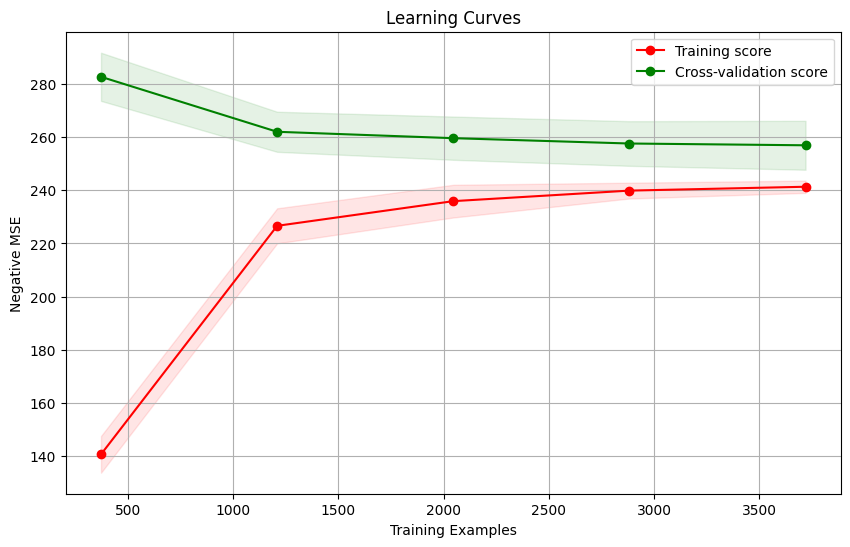

In [115]:
test_data = data.query("year >= 2022")
train_data = data.query("year < 2022")

y = train_data['margin']
X = train_data.drop(columns=excluded)
X_train, X_cv, y_train, y_cv = train_test_split(X, y, test_size=0.2, random_state=42)

# Train the model with every feature
model = train_model(X_train, y_train, X_cv, y_cv)
plot_learning_curve(model, X, y)

Best Hyperparameters: {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 300}
Root Mean Squared Error (RMSE) of Best Model: 16.1126840777624
Mean Absolute Error (MAE) of cross validation data: 12.713754468648489


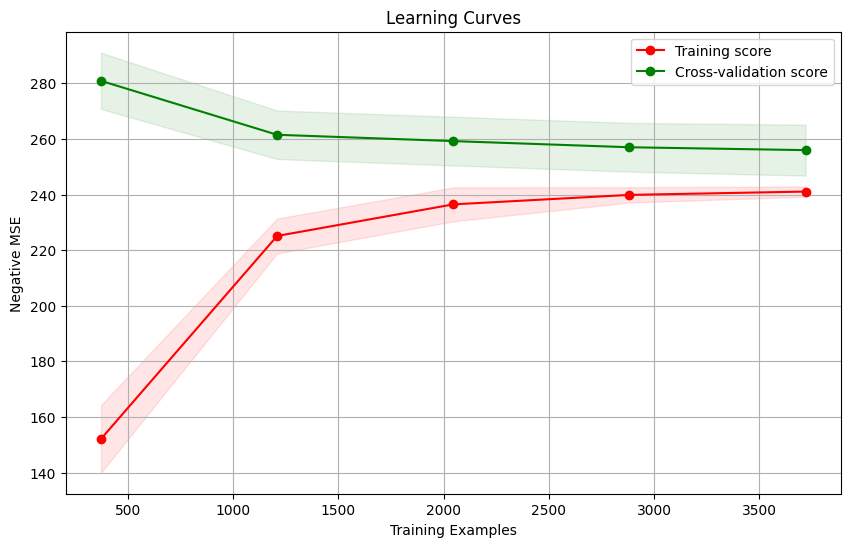

In [116]:
# Train the model with the difference of home and away features
features_to_diff = ['talent', 'elo', 'coaches_poll_points', 'ap_top_25_points', 'cumulative_penalties',
                    'cumulative_possession_time', 'cumulative_turnovers', 'cumulative_sacks',
                    'cumulative_tackles_for_loss', 'cumulative_first_downs', 'cumulative_passingsTDs',
                    'cumulative_rushingTDs', 'cumulative_offense_ppa', 'cumulative_defense_ppa',
                    'cumulative_offense_success_rate', 'cumulative_defense_success_rate',
                    'cumulative_offense_explosiveness', 'cumulative_defense_explosiveness',
                    'cumulative_offense_points_per_opportunity', 'cumulative_defense_points_per_opportunity',
                    'cumulative_offense_havoc', 'cumulative_defense_havoc']

diff_data = pd.DataFrame() 

additional_columns = ['year', 'margin', 'neutral_site', 'spread', 'home_conference_encoded', 'away_conference_encoded']
for col in additional_columns:
    diff_data[col] = data[col]
    
for feature in features_to_diff:
    home_col = f'home_{feature}'
    away_col = f'away_{feature}'
    diff_col = f'diff_{feature}'
    diff_data[diff_col] = data[home_col] - data[away_col]

test_diff_data = diff_data.query("year >= 2022")
train_diff_data = diff_data.query("year < 2022")

columns_to_drop = [col for col in excluded if col in diff_data.columns]

diff_y = train_diff_data['margin']
diff_X = train_diff_data.drop(columns=columns_to_drop)
diff_X_train, diff_X_cv, diff_y_train, diff_y_cv = train_test_split(diff_X, diff_y, test_size=0.2, random_state=42)

diff_model = train_model(diff_X_train, diff_y_train, diff_X_cv, diff_y_cv)
plot_learning_curve(diff_model, diff_X, diff_y)

# Data Visualization

Root Mean Squared Error (RMSE) of CV P5 vs P5 games: 16.37316960053439
Root Mean Squared Error (RMSE) of CV non-P5 games: 16.78170759177978


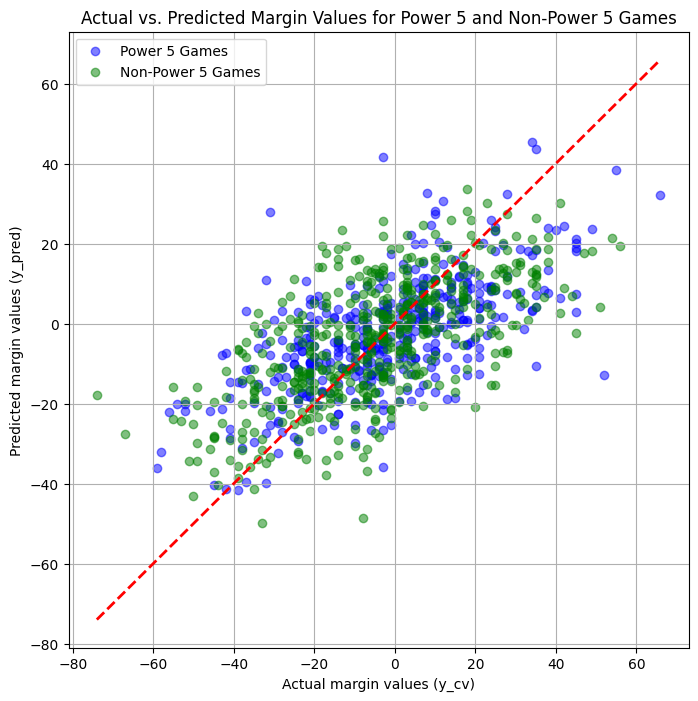

In [59]:
# The specific encoded conference values for power 5 teams
p5_conference_values = [0, 2, 5, 13, 14]

# Filter the CV data based on the power 5 conference values
p5_X_cv = X_cv[(X_cv['home_conference_encoded'].isin(p5_conference_values)) & (X_cv['away_conference_encoded'].isin(p5_conference_values))]
p5_y_cv = y_cv[(X_cv['home_conference_encoded'].isin(p5_conference_values)) & (X_cv['away_conference_encoded'].isin(p5_conference_values))]
p5_y_pred = model.predict(p5_X_cv)

# Filter the CV data based on the non-power 5 conference values
non_p5_X_cv = X_cv[~(X_cv['home_conference_encoded'].isin(p5_conference_values)) | ~(X_cv['away_conference_encoded'].isin(p5_conference_values))]
non_p5_y_cv = y_cv[~(X_cv['home_conference_encoded'].isin(p5_conference_values)) | ~(X_cv['away_conference_encoded'].isin(p5_conference_values))]
non_p5_y_pred = model.predict(non_p5_X_cv)

mse_p5 = mean_squared_error(p5_y_cv, p5_y_pred)
rmse_p5 = mse_p5 ** 0.5
print(f"Root Mean Squared Error (RMSE) of CV P5 vs P5 games: {rmse_p5}")

mse_non_p5 = mean_squared_error(non_p5_y_cv, non_p5_y_pred)
rmse_non_p5 = mse_non_p5 ** 0.5
print(f"Root Mean Squared Error (RMSE) of CV non-P5 games: {rmse_non_p5}")

# Scatter plot for P5 teams (in blue)
plt.figure(figsize=(8, 8))
plt.scatter(p5_y_cv, p5_y_pred, alpha=0.5, c='blue', label='Power 5 Games')
# Scatter plot for Non-P5 teams (in green)
plt.scatter(non_p5_y_cv, non_p5_y_pred, alpha=0.5, c='green', label='Non-Power 5 Games')

# Plot a diagonal red dashed line
plt.plot([min(y_cv), max(y_cv)], [min(y_cv), max(y_cv)], color='red', linestyle='--', lw=2)
plt.xlabel("Actual margin values (y_cv)")
plt.ylabel("Predicted margin values (y_pred)")
plt.title("Actual vs. Predicted Margin Values for Power 5 and Non-Power 5 Games")
plt.grid(True)
plt.legend()
plt.show()


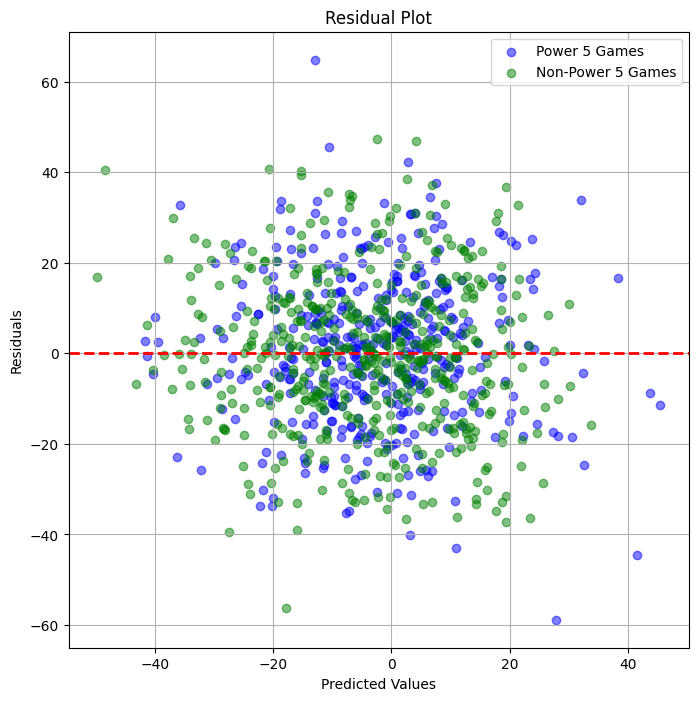

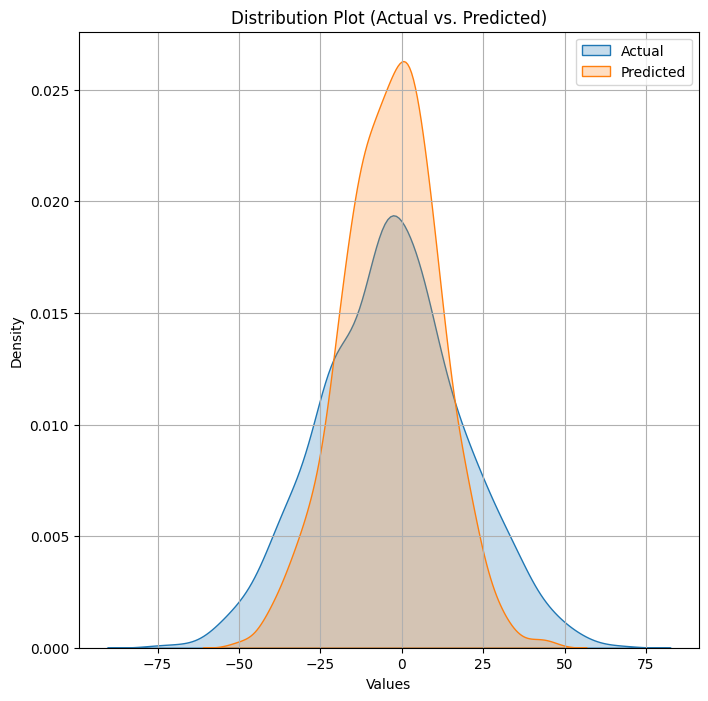

In [61]:
# 1. Residual Plot - plot the residuals against predicted values.
residuals = y_cv - y_pred
# plt.figure(figsize=(8, 8))
# plt.scatter(y_pred, residuals, alpha=0.5)
# plt.axhline(y=0, color='black', linestyle='--', linewidth=1)  # Add a horizontal line at y=0
# plt.xlabel("Predicted Values")
# plt.ylabel("Residuals")
# plt.title("Residual Plot")
# plt.grid(True)
# plt.show()


# Assuming you have a binary indicator for P5 games in your data called 'is_P5_game'

# Filter data for P5 and non-P5 games
P5_residuals = residuals[(X_cv['home_conference_encoded'].isin(p5_conference_values)) & (X_cv['away_conference_encoded'].isin(p5_conference_values))]
non_P5_residuals = residuals[~(X_cv['home_conference_encoded'].isin(p5_conference_values)) | ~(X_cv['away_conference_encoded'].isin(p5_conference_values))]

# Create a residual plot with different colors
plt.figure(figsize=(8, 8))
plt.scatter(y_pred[(X_cv['home_conference_encoded'].isin(p5_conference_values)) & (X_cv['away_conference_encoded'].isin(p5_conference_values))], P5_residuals, alpha=0.5, label='Power 5 Games', color='blue')
plt.scatter(y_pred[~(X_cv['home_conference_encoded'].isin(p5_conference_values)) | ~(X_cv['away_conference_encoded'].isin(p5_conference_values))], non_P5_residuals, alpha=0.5, label='Non-Power 5 Games', color='green')
plt.axhline(y=0, color='red', linestyle='--', lw=2)  # Add a horizontal line at y=0

plt.xlabel("Predicted Values")
plt.ylabel("Residuals")
plt.title("Residual Plot")
plt.grid(True)
plt.legend()  # Add a legend to distinguish P5 and non-P5 games
plt.show()




# 2. Distribution Plot - a density plot or histogram for both the actual and predicted values on the same graph to compare their distributions
plt.figure(figsize=(8, 8))
sns.kdeplot(y_cv, label="Actual", fill=True)
sns.kdeplot(y_pred, label="Predicted", fill=True)
plt.xlabel("Values")
plt.ylabel("Density")
plt.title("Distribution Plot (Actual vs. Predicted)")
plt.legend()
plt.grid(True)
plt.show()

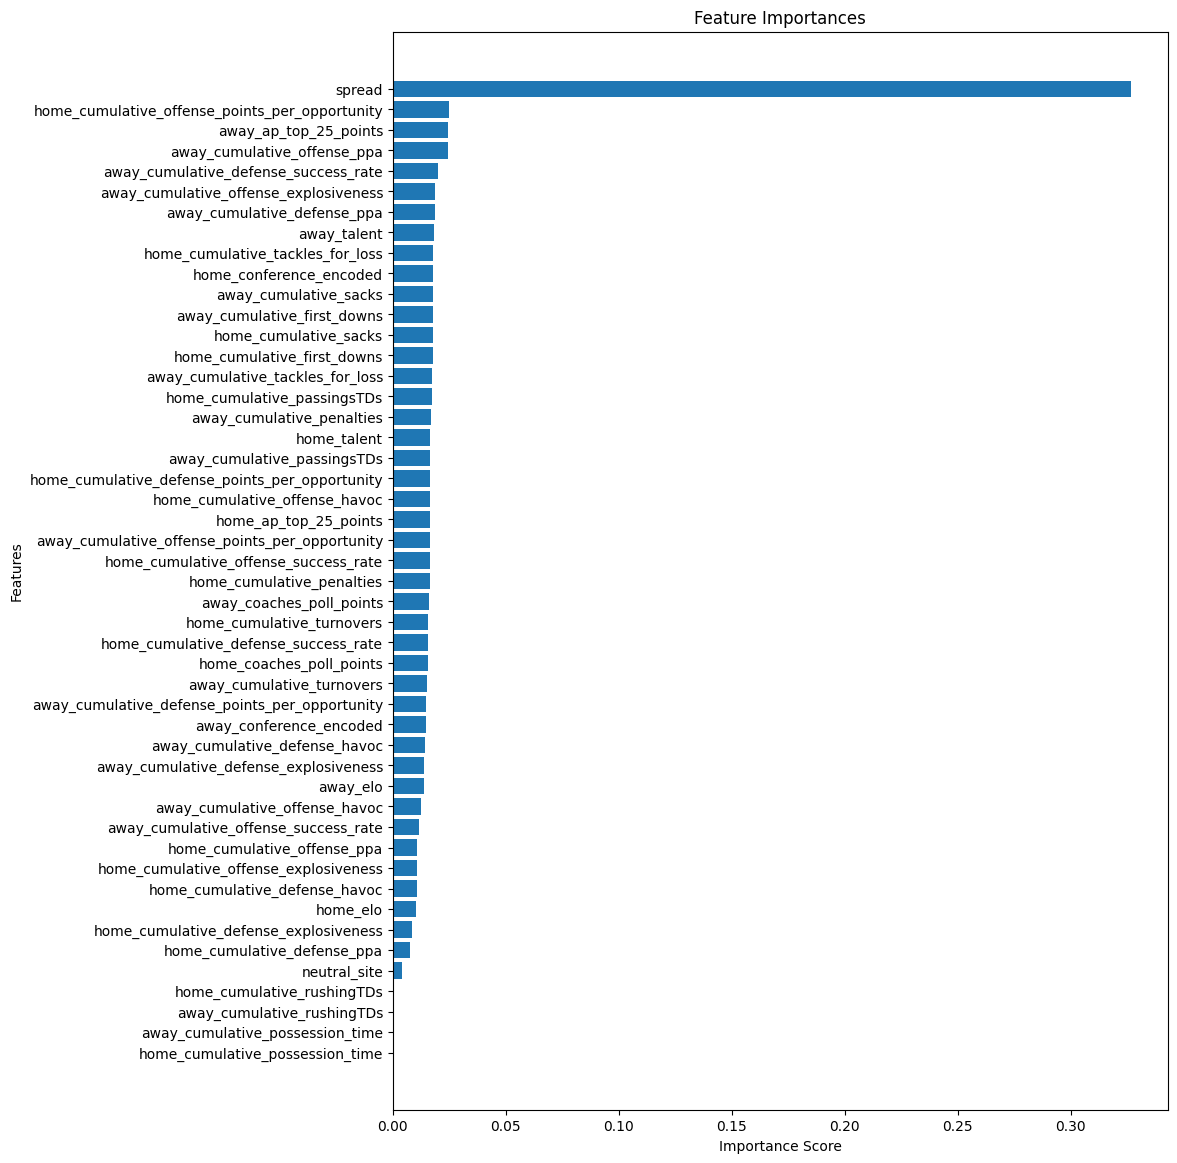

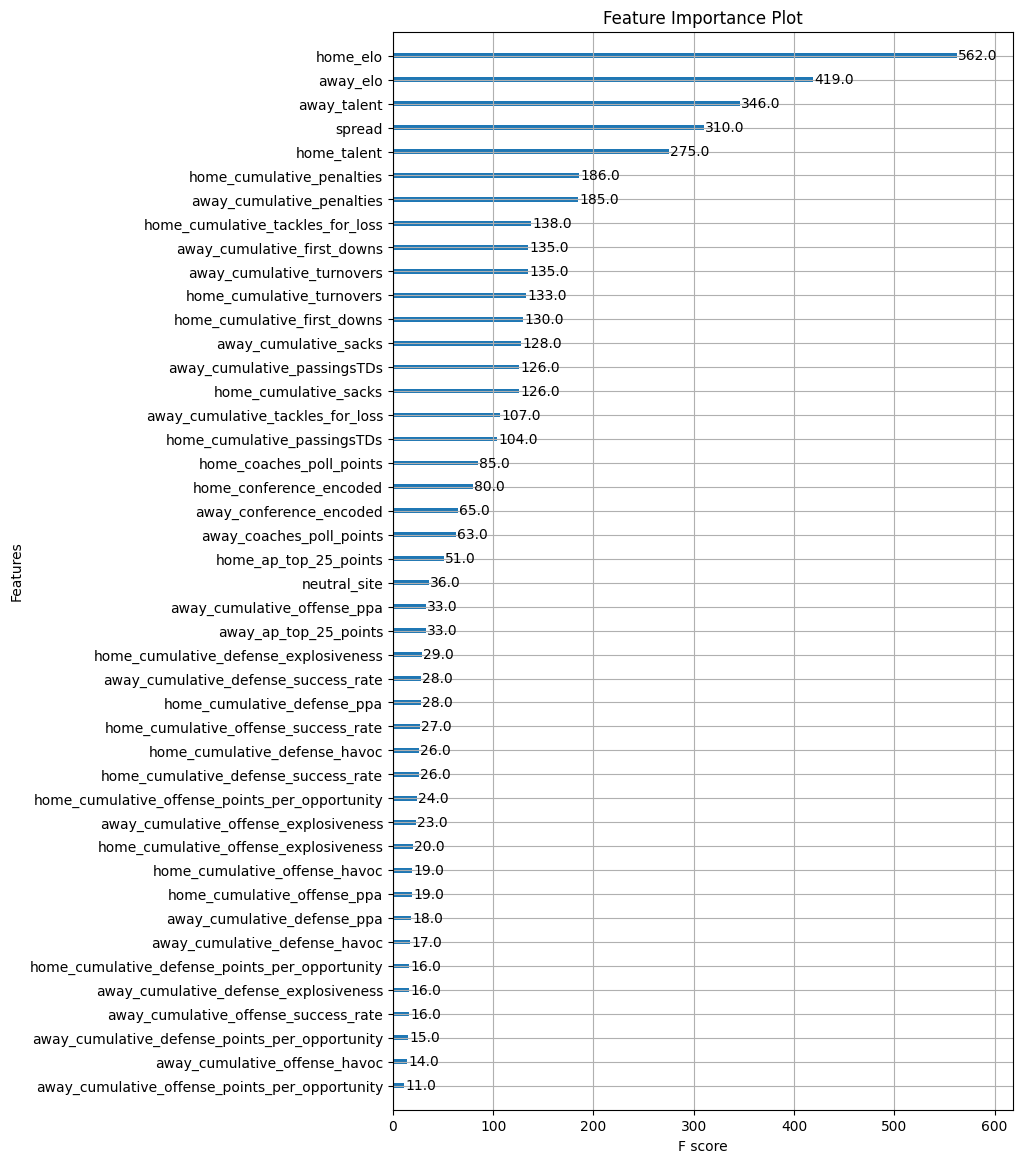

In [15]:
# If "home_elo" is showing as a significant feature in one plot but not in the other, it might indicate that while it's frequently used for splitting, 
# its impact on model performance (measured in terms of reducing prediction error) might not be as high as other features. 

# First plot ranks how many times each feature is used for splitting across all of the decision trees
# Second plot not sure the difference...

# Get feature importances
importance_scores = model.feature_importances_
feature_importance_df = pd.DataFrame({'Feature': X_train.columns, 'Importance': importance_scores})
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=True)

# Plot the feature importances
plt.figure(figsize=(10, 14))
plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance'])
plt.xlabel('Importance Score')
plt.ylabel('Features')
plt.title('Feature Importances')
plt.show()

# ”weight” is the number of times a feature appears in a tree
fig, ax = plt.subplots(figsize=(8, 14))
xgb.plot_importance(model, importance_type='weight', ax=ax)
plt.title("Feature Importance Plot")
plt.show()

C:\Users\tyhal\AppData\Roaming\Python\Python311\site-packages\sklearn\inspection\_plot\partial_dependence.py:972: UserWarning: Attempting to set identical low and high ylims makes transformation singular; automatically expanding.
  ax.set_ylim([min_val, max_val])
C:\Users\tyhal\AppData\Roaming\Python\Python311\site-packages\sklearn\inspection\_plot\partial_dependence.py:972: UserWarning: Attempting to set identical low and high ylims makes transformation singular; automatically expanding.
  ax.set_ylim([min_val, max_val])


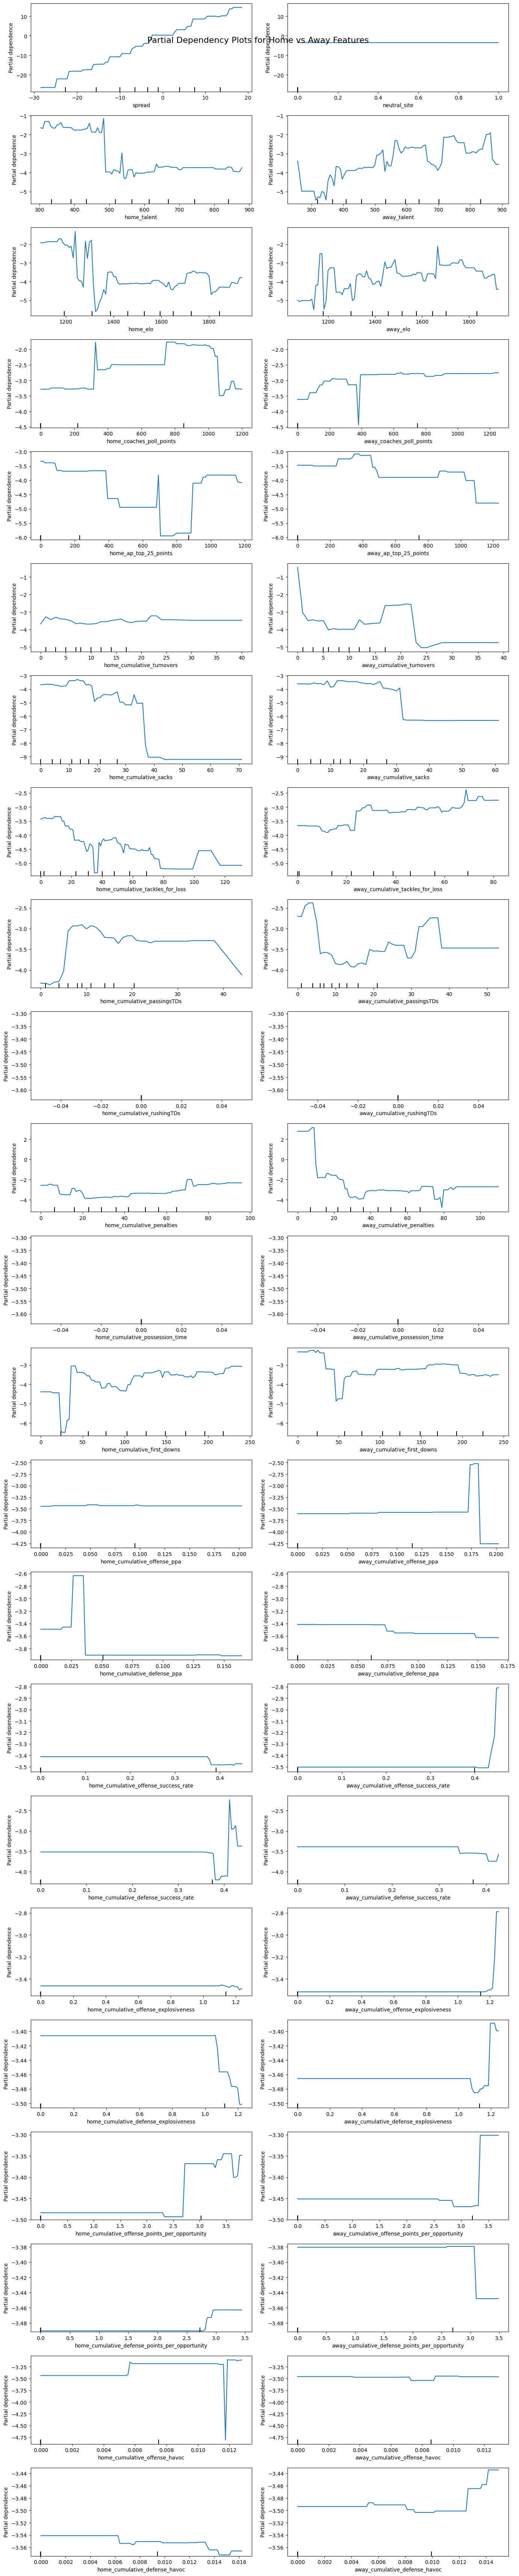

In [58]:
# Create PDPs for specific features
feature_groups = [
    ["spread", "neutral_site"],
    ["home_talent", "away_talent"],
    ["home_elo", "away_elo"],
    ["home_coaches_poll_points", "away_coaches_poll_points"],
    ["home_ap_top_25_points", "away_ap_top_25_points"],
    ["home_cumulative_turnovers", "away_cumulative_turnovers"],
    ['home_cumulative_sacks', 'away_cumulative_sacks'],
    ['home_cumulative_tackles_for_loss', 'away_cumulative_tackles_for_loss'],
    ['home_cumulative_passingsTDs', 'away_cumulative_passingsTDs'],
    ['home_cumulative_rushingTDs', 'away_cumulative_rushingTDs'],
    ['home_cumulative_penalties', 'away_cumulative_penalties'],
    ['home_cumulative_possession_time', 'away_cumulative_possession_time'],
    ["home_cumulative_first_downs", "away_cumulative_first_downs"],
    ['home_cumulative_offense_ppa','away_cumulative_offense_ppa'],
    ['home_cumulative_defense_ppa', 'away_cumulative_defense_ppa'],
    ['home_cumulative_offense_success_rate', 'away_cumulative_offense_success_rate'],
    ['home_cumulative_defense_success_rate', 'away_cumulative_defense_success_rate'],
    ['home_cumulative_offense_explosiveness', 'away_cumulative_offense_explosiveness'],
    ['home_cumulative_defense_explosiveness', 'away_cumulative_defense_explosiveness'],
    ['home_cumulative_offense_points_per_opportunity', 'away_cumulative_offense_points_per_opportunity'],
    ['home_cumulative_defense_points_per_opportunity', 'away_cumulative_defense_points_per_opportunity'],
    ['home_cumulative_offense_havoc', 'away_cumulative_offense_havoc'],
    ['home_cumulative_defense_havoc', 'away_cumulative_defense_havoc']
]
height_per_plot = 3
fig, axes = plt.subplots(len(feature_groups), 2, figsize=(14, 3 * len(feature_groups)))

for feature_pair in feature_groups:
    PartialDependenceDisplay.from_estimator(model, X_cv, feature_pair, ax=axes[feature_groups.index(feature_pair)])

plt.tight_layout()

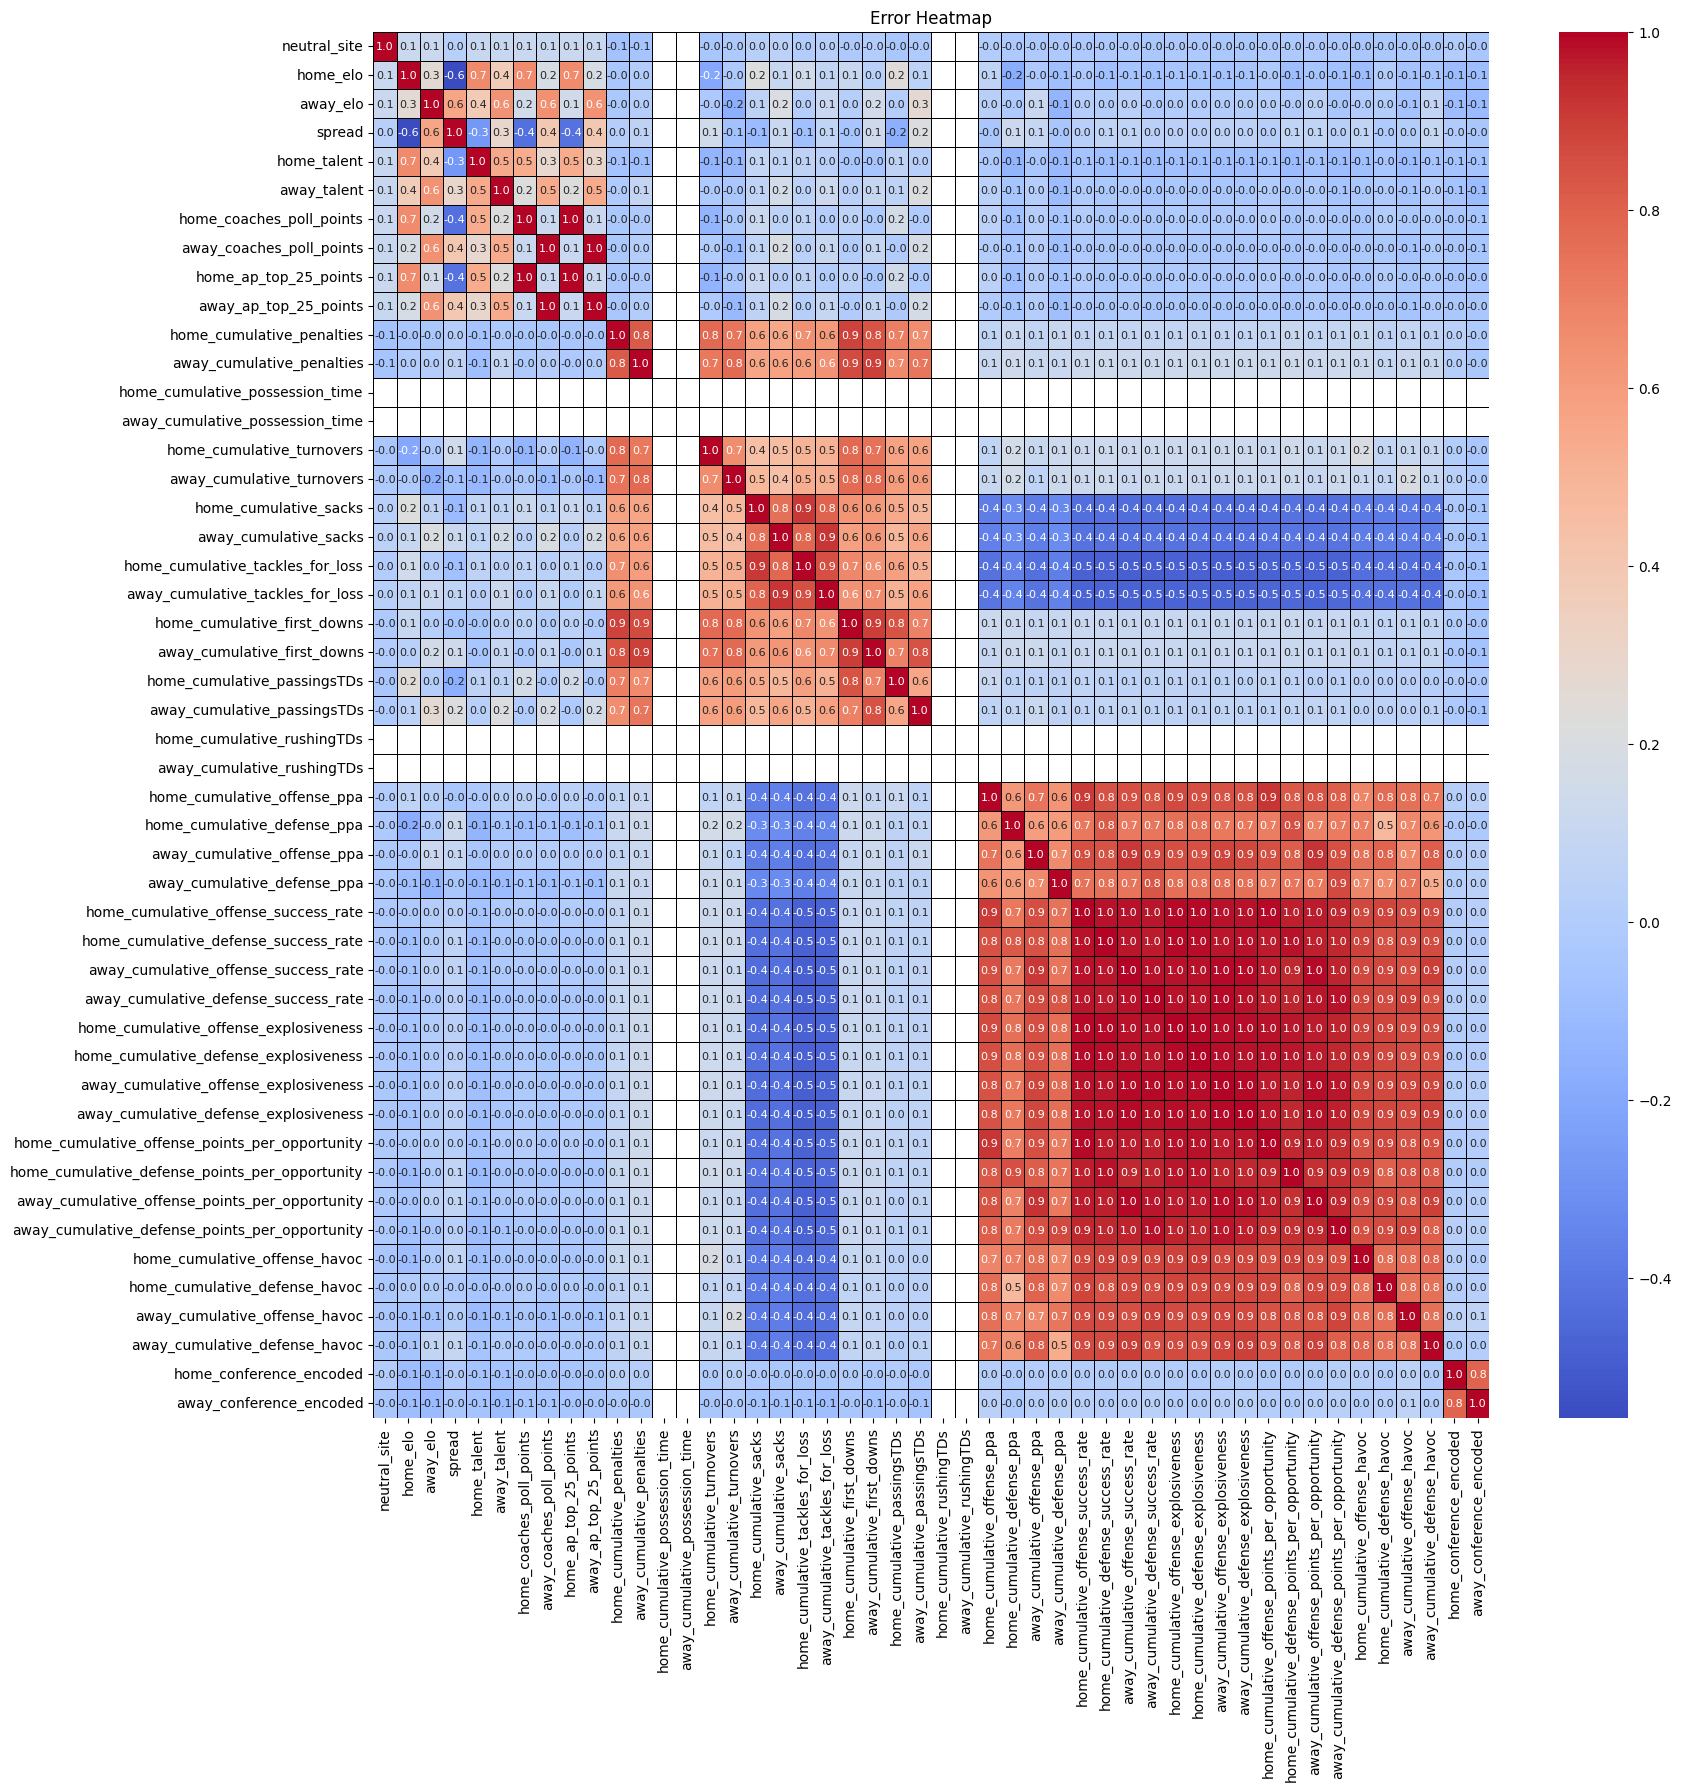

In [54]:
# 4. Error Heatmap - shows errors for different combinations of features, helping to identify feature interactions affecting the model.
plt.figure(figsize=(18, 18))
plt.title("Error Heatmap")
annot_font_size = 8  # Adjust to your preference
correlation_matrix = X_cv.corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', annot_kws={"size": annot_font_size}, fmt=".1f", linewidths=0.5, linecolor='black')
plt.show()